In [0]:
""" Paste the function in the console to keep Colab active to prevent timeout.

function ClickConnect(){console.log("Working");document.querySelector("colab-toolbar-button#connect").click()}setInterval(ClickConnect,60000)

function ClickConnect(){console.log("Working");document.querySelector("#private-outputs-warning").click()}setInterval(ClickConnect,60000)
"""

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=False)

!ls "/content/drive/My Drive"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Import Common Packages

In [196]:
import pandas as pd
import numpy as np

import _pickle as pickle
from collections import Counter
from pprint import pprint
from datetime import datetime
import shutil

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## ~~Loading from training data directory (supports batch mode)~~

In [197]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# from torchvision.datasets import DatasetFolder

In [0]:
# TRAIN_DIR = '../training_data/'

In [0]:
# from torch.utils.data import Dataset, DataLoader
# from torchvision.datasets import DatasetFolder

# def pickle_loader(input_path):
#     f = open(input_path, 'rb')
#     data = pickle.load(f)

#     return { 'segment': data[0], 'label': data[1] }
# #     return data[0], data[1]


# # TODO: decide on what transformation to perform
# def transform_input(input):
#     """
#     Transform input so that all input samples in the batch have same size.
#     Note: this is not required if the batch size is 1 for the data loader.
#     """
#     num_frames = 3
    
#     return { 'segment': input['segment'][:num_frames], 'label': input['label'] }
# #     return input[:num_frames]

In [0]:
# # https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder
# # Directory should be 'TRAIN_DIR/data/*.doc'
# train_data = DatasetFolder(root=TRAIN_DIR, 
#                            loader=pickle_loader, 
#                            extensions='.doc', 
#                            transform=transform_input
#                           )

# train_loader = torch.utils.data.DataLoader(dataset=train_data,
#                                            batch_size=4,
#                                            num_workers=0,
#                                            shuffle=False
#                                           )

# for batch_idx, batch_data in enumerate(train_loader):
#     input_samples = batch_data[0]['segment'] # Same length as batch size
#     input_labels = batch_data[0]['label']

# #     x = Variable(input_samples)
# #     out = model(x)
# # https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

## Loading from single training data file

In [195]:
ROOR_DIR = "/content/drive/My Drive/" # "../"

DATA_DIR = ROOR_DIR
RESULTS_DIR = ROOR_DIR + "results/"

TRAINING_DATA = DATA_DIR + "training_data.p"
VALIDATION_DATA = DATA_DIR + "validation_data.p"
TEST_DATA = DATA_DIR + "testing_data.p"

### Data Analysis

#### TODO: decide on batch sizes, and sort input data by segment lengths + validation dataset

Store file pointer position as `{ segment_idx: file_ptr_offset }`.

Then use `seek()` to read segment from the offset position to create the new data file which is sorted by segment length.

In [188]:
f = open(TRAINING_DATA, 'rb')

labels = []
segment_lengths = []
segment_idx = 0
while True:
    try:
        (segment, label) = pickle.load(f)
        
        labels.append(label)
        segment_lengths.append((segment_idx, len(segment)))
        segment_idx += 1
    except (EOFError):
        break

f.close()

sorted_segment_lengths = sorted(segment_lengths, key=lambda tup: tup[1])
lengths = [seg_len[1] for seg_len in segment_lengths]

df = pd.DataFrame({'seg_len': lengths})
display(df.describe())

length_counts = Counter(lengths)
# pprint(sorted(counts.items(), key=lambda i: i[0]))

,seg_len
count,7075.000000
mean,404.351802
std,553.041997
min,8.000000
25%,134.000000
50%,234.000000
75%,425.500000
max,5791.000000


In [ ]:
fig = plt.figure(figsize=(15,5))

# plt.hist(labels, bins=150)
label_counts = Counter(labels)
plt.bar(label_counts.keys(), label_counts.values())

plt.gca().set_title('Distribution of Class labels in training data')
plt.xlabel('Label Index')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

Text(0, 0.5, 'Number of segments (frequency)')

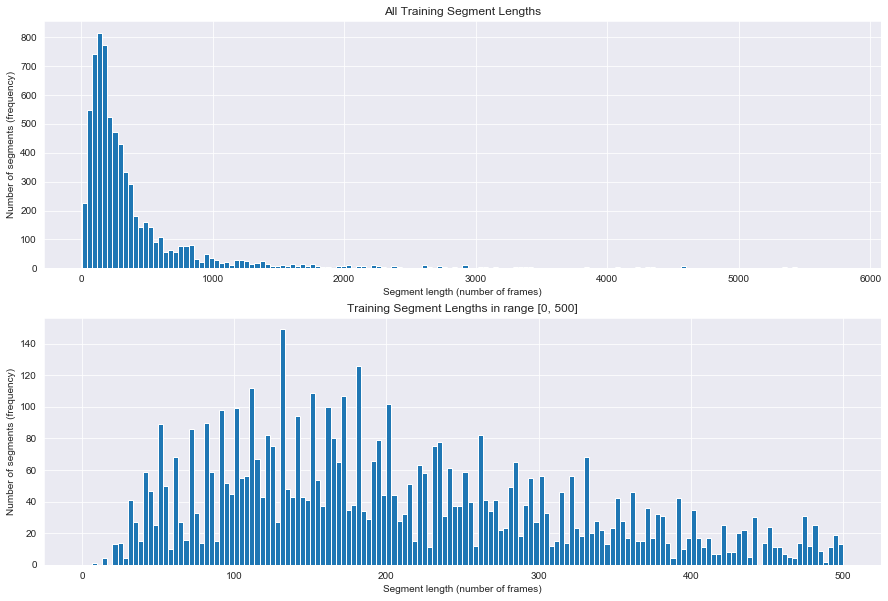

In [45]:
fig = plt.figure(figsize=(15,10))

plt.subplot(2, 1, 1)
plt.hist(lengths, bins=150)
# plt.bar(length_counts.keys(), length_counts.values())

plt.gca().set_title('All Training Segment Lengths')
plt.xlabel('Segment length (number of frames)')
plt.ylabel('Number of segments (frequency)')

plt.subplot(2, 1, 2)
plt.hist(lengths, bins=150, range=[0, 500])

plt.gca().set_title('Training Segment Lengths in range [0, 500]')
plt.xlabel('Segment length (number of frames)')
plt.ylabel('Number of segments (frequency)')

## Simple RNN Model

- [Pytorch RNN](https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/#step-3-create-model-class)
- [Tensorflow Keras RNN](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/keras/rnn.ipynb) 

In [49]:
import torch
import torch.nn as nn
from torch import optim
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [186]:
def transform_input(segments):
    """
    Transform input with zero padding so that all input segments 
    in the batch have same size.
    """
    input_dim = 400 # num features in an i3D frame
    segment_lengths = [len(segments) for segments in segments]
    
    # Create an empty matrix with zero padding
    longest_segment = max(segment_lengths)
    batch_size = len(segments)
    padded_segments = np.zeros((batch_size, longest_segment, input_dim))
    
    # Copy over the actual frame sequences
    for i, length in enumerate(segment_lengths):
        sequence = segments[i]
        padded_segments[i, 0:length] = sequence[:length]
    
    # Change back to tensor of type double
    transformed_segments = []
    for padded_segment in padded_segments:
        transformed_segments.append(torch.Tensor(padded_segment).double())
    
    return transformed_segments

In [ ]:
def get_next_data_batch(f, batch_size):    
    raw_segments = []
    labels = []
    
    is_end_reached = False
    
    num_segments = 0
    while num_segments < batch_size:
        try:
            (segment, label) = pickle.load(f)
            
            raw_segments.append(segment)
            labels.append(label)
            num_segments += 1
        except (EOFError):
            is_end_reached = True
            break

    padded_segments = transform_input(raw_segments)
    segments = torch.stack(padded_segments).double()
    labels = torch.Tensor(labels).long()
    
    return segments, labels, is_end_reached

In [134]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, segment_len, input_dim)

        # Initialize hidden state with zeros: (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).double().requires_grad_()

        # Detach hidden state to prevent exploding/vanishing gradients (Truncated BPTT)
        # rnn_out: (batch_size, time_step, output_dim)
        rnn_out, hn = self.rnn(x, h0.detach())

        # Predict using hidden states of last time step  
        # out: (batch_size, output_dim)
        out = self.fc(rnn_out[:, -1, :]) 

        return out

# Train Model

In [165]:
def save_checkpoint(state, filename=RESULTS_DIR + 'model_checkpoint.pth'):
    torch.save(state, filename)

def train_model(model, batch_sizes, num_epochs=10, train_data_file=TRAINING_DATA, validation_data_file=VALIDATION_DATA):
    training_losses = []
    validation_losses = []

    batch_size = 100 # TODO: use batch_sizes instead
    
    for epoch in range(num_epochs):
        print('======================================================================')
        print('Epoch: {}'.format(epoch))

        try:
            train_f.close()    
        except(NameError):
            ;   
        
        train_f = open(train_data_file, 'rb')
        should_epoch_end = False

        iter = 0
        epoch_training_losses = []

        # for i, (segments, labels) in get(train_loader):        
        while not should_epoch_end:
            model.train()
            
            segments, labels, should_epoch_end = get_next_data_batch(train_f, batch_size)
            
            # Load segments as tensors with gradient accumulation abilities
            segments = segments.requires_grad_()

            optimizer.zero_grad()

            outputs = model(segments)

            loss = loss_criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            epoch_training_losses.append(loss.item())

            iter += 1
            if iter % 10 == 0:
                print('    Iteration: {}. Loss: {}.'.format(iter, loss.item())) 
                
#                 # Evaluate on validation set
#                 model.eval()

#                 correct = 0
#                 total = 0
#                 for images, labels in test_loader:
#                     # Load images to a Torch tensors with gradient accumulation abilities
#                     images = images.view(-1, seq_dim, input_dim)

#                     outputs = model(images)

#                     _, predicted = torch.max(outputs.data, 1)

#                     total += labels.size(0)
#                     correct += (predicted == labels).sum()

#                 accuracy = 100 * correct / total

#                 Print Loss
#                 print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

                
        training_losses.append(epoch_training_losses)
        train_f.close()    
        
        scheduler.step(np.mean(epoch_training_losses))

        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        })

        
    return training_losses, validation_losses

In [166]:
time = str(datetime.now().strftime("%Y-%m-%d-_%I-%M-%S"))

## Model Architecture
input_dim = 400  # dimension of an i3D video frame
hidden_dim = 100 # dimension of RNN hidden state
layer_dim = 1    # number of hidden RNN layers
output_dim = 48  # number of sub-action labels

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
model = model.double() # transform the model parameters to double precision


## Loss function
loss_criterion = nn.CrossEntropyLoss()


## Optimizer
learning_rate = 0.01
weight_decay = 0.002
momentum = 0.9

optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 


## Learning Rate Scheduler
patience = 3
decrease_factor = 0.5
min_learning_rate = 0.00005
scheduler = ReduceLROnPlateau(optimizer, mode='min', 
                              patience=patience, min_lr=min_learning_rate, factor=decrease_factor,
                              verbose=True)


num_epochs = 1

training_losses, validation_losses = train_model(model, batch_sizes=[], num_epochs=num_epochs) # TODO: batch_sizes

path = RESULTS_DIR + "%s_rnn_model.pth" % (time)
torch.save(model.state_dict(), path)
print("\nSaved trained model to", path)

Epoch: 0
    Iteration: 10. Loss: 3.823301838057682.
    Iteration: 20. Loss: 3.7799726319884996.
    Iteration: 30. Loss: 3.7859219249326426.
    Iteration: 40. Loss: 3.9671365179331017.
    Iteration: 50. Loss: 3.6804156010578235.
    Iteration: 60. Loss: 3.672719170587443.
    Iteration: 70. Loss: 3.722281479866212.


NameError: name 'net' is not defined

In [168]:
path = RESULTS_DIR + "%s_rnn_model.pth" % (time)
torch.save(model.state_dict(), path)
print("\nSaved trained model to", path)


Saved trained model to ../results/2020-03-21-_04-30-14_rnn_model.pth


In [ ]:
# # Plot training and validation losses
# training_losses = training_losses.mean()
# validation_losses = validation_losses.mean()

# plt.figure(figsize=(12,6))
# plt.title("Average batch Training and validation loss in each epoch")
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.plot(training_losses)
# plt.plot(validation_losses)
# plt.legend(["Training loss","Validation loss"])

In [ ]:
# # Load saved checkpoint
# checkpoint_path = RESULTS_DIR + "model_checkpoint.pth"
# checkpoint = torch.load(checkpoint_path)

# epoch = checkpoint['epoch']
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])

# print("=> loaded checkpoint '{}' (epoch {})".format(checkpoint_path, epoch))

# # # Load saved model
# # path = RESULTS_DIR + "2020-03-21-_04-30-14_rnn_model.pth"
# # model.load_state_dict(torch.load(path))

# Evaluation Results (on validation data)

In [ ]:
model.eval()

try:
    val_f.close()    
except(NameError):
    ;   
val_f = open(VALIDATION_DATA, 'rb')

y = {'Actual': [], 'Predicted': []}

is_end_reached = False
while not is_end_reached:
    segments, labels, is_end_reached = get_next_data_batch(val_f, 1)

    outputs = model(segments)
    _, predicted = torch.max(outputs.data, 1)
    
    y['Actual'].extend(labels.tolist())
    y['Predicted'].extend(predicted.tolist())
    
y = pd.DataFrame(y)
path = RESULTS_DIR + "%s_prediction_results.csv" % (str(time))        
y.to_csv(path, encoding='utf-8', index=False)

In [ ]:
fig = plt.figure(figsize=(10,4))

y_err = np.subtract(y['Predicted'], y['Actual'])
err_counts = Counter(y_err)

plt.bar(err_counts.keys(), err_counts.values())
plt.gca().set_title("Model's Prediction Errors- Frequency vs (Predicted - Actual)")
plt.xlabel('(Predicted-Actual)')
plt.ylabel('Frequency')

In [ ]:
contingency_df = pd.crosstab(y['Predicted'], y['Actual'])
# display(contingency_df)

fig = plt.figure(figsize=(25,25))

g = sns.heatmap(contingency_df, annot=True)
g.set_yticklabels(g.get_yticklabels(), rotation = 0);

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

print('\nMacro f1 Score= %.4f' % f1_score(y['Actual'], y['Predicted'], average="macro"))
print('Macro Precision= %.4f' % precision_score(y['Actual'], y['Predicted'], zero_division=0, average="macro"))
print('Macro Recall= %.4f' % recall_score(y['Actual'], y['Predicted'], average="macro")) 

print('\nMicro f1 Score= %.4f' % f1_score(y['Actual'], y['Predicted'], average="micro"))
print('Micro Precision= %.4f' % precision_score(y['Actual'], y['Predicted'], zero_division=0, average="micro"))
print('Micro Recall= %.4f' % recall_score(y['Actual'], y['Predicted'], average="micro")) 

print('\nAccuracy: %.4f' % accuracy_score(y['Actual'], y['Predicted']))

# Computes the average AUC of all possible pairwise combinations of classes. 
# Insensitive to class imbalance when average == 'macro'.
print(roc_auc_score(y['Actual'], y['Predicted'], multi_class='ovo', average='macro')) 

In [ ]:
from scipy import interp

from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

report_with_auc = class_report(y_true=np.array(y['Actual']),y_pred=np.array(y['Predicted']))
display(report_with_auc)

## Make predictions on unseen test data (i.e. Kaggle submission)

In [174]:
def get_next_test_batch(f, batch_size=1):    
    raw_segments = []
    labels = []
    
    is_end_reached = False
    
    num_segments = 0
    while num_segments < batch_size:
        try:
            segment = pickle.load(f)
            
            raw_segments.append(segment)
            labels.append(label)
            num_segments += 1
        except (EOFError):
            is_end_reached = True
            break

    padded_segments = transform_input(raw_segments)
    segments = torch.stack(padded_segments).double()
    labels = torch.Tensor(labels).long()
    
    return segments, is_end_reached

In [187]:
model.eval()

try:
    test_f.close()    
except(NameError):
    ;   
test_f = open(TEST_DATA, 'rb')

y = {'Predicted': []}

is_end_reached = False
while not is_end_reached:
    segments, is_end_reached = get_next_test_batch(test_f, 50)

    outputs = model(segments)
    _, predicted = torch.max(outputs.data, 1)
    
    y['Predicted'].extend(predicted.tolist())

y = pd.DataFrame(y)
path = RESULTS_DIR + "%s_predictions_submission.csv" % (str(time))        
y.to_csv(path, encoding='utf-8', index=False)